## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

import m5.config as cfg
import m5.preprocessing
from m5.evaluate import calculate_rmsse

import lightgbm as lgb
import gc

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)

In [3]:
feature_names = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
    'sell_price', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3',
    'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7',
    'sales_lag_8', 'sales_lag_9', 'sales_lag_10', 'sales_lag_11',
    'sales_lag_12', 'sales_lag_13', 'sales_lag_14',
]

categorical_features = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
]

## Preprocessing

In [6]:
m5.preprocessing.prepare_base_data(cfg.DATA_DIR, cfg.DATA_PROCESSED_DIR)

In [7]:
m5.preprocessing.prepare_dataset(cfg.DATA_PROCESSED_DIR, cfg.TARGET, cfg.FH, cfg.N_LAGS)

In [8]:
m5.preprocessing.prepare_train_val_split(cfg.DATA_PROCESSED_DIR, cfg.FH)

In [10]:
m5.preprocessing.prepare_dataset_binaries(cfg.DATA_PROCESSED_DIR, feature_names, categorical_features)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Construct bin mappers from text data time 0.44 seconds
[LightGBM] [Info] Saving data to binary file /home/ariel/Playground/m5-forecasting/data/processed/train.bin
[LightGBM] [Info] Saving data to binary file /home/ariel/Playground/m5-forecasting/data/processed/val.bin


In [ ]:
m5.preprocessing.prepare_train_bu(cfg.DATA_PROCESSED_DIR)

## Train

In [25]:
train = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "train.bin"))
val = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "val.bin"))

In [26]:
lgbm_params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 1000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 4,
    "early_stopping_round": 100,
}

In [27]:
model = lgb.train(lgbm_params, train, valid_sets=[val])

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Load from binary file /home/ariel/Playground/m5-forecasting/data/processed/train.bin
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.209090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33273
[LightGBM] [Info] Number of data points in the train set: 43838692, number of used features: 32
[LightGBM] [Info] Start training from score 0.355291
[1]	valid_0's tweedie: 4.59635
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 4.49861
[3]	valid_0's tweedie: 4.41368
[4]	valid_0's tweedie: 4.34135
[5]	valid_0's tweedie: 4.27989
[6]	valid_0's tweedie: 4.22724
[7]	valid_0's tweedie: 4.18187
[8]	valid_0's tweedie: 4.14339
[9]	valid_0's tweedie: 4.11026
[10]	valid_0's tweedie: 4.08225
[11]	valid_0's tweedie: 4.05866
[12]	valid_0's tweedie: 4.0382
[13]	valid_0's tweedie: 4.02057
[14]	valid_0's t

In [28]:
model.save_model(str(cfg.ROOT_DIR / "models/model_lvl_12.txt"))

## Predict

In [20]:
val = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "val.parquet")

In [21]:
train = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "train.parquet")

In [22]:
model = lgb.Booster(model_file=str(cfg.MODEL_DIR / "model_lvl_12.txt"))

In [23]:
fcst_df = val[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "d", "sales"]].copy()
fcst_df["fcst"] = model.predict(val.drop(columns=["sales"]))

<AxesSubplot:xlabel='d'>

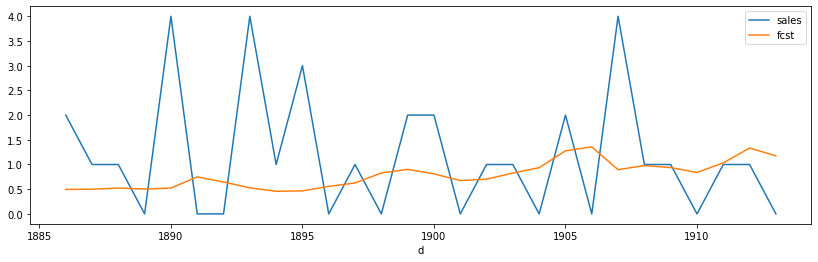

In [24]:
ID = 0
fcst_df.loc[val.id == ID, ["sales", "fcst", "d"]].set_index("d").plot()

<AxesSubplot:xlabel='d'>

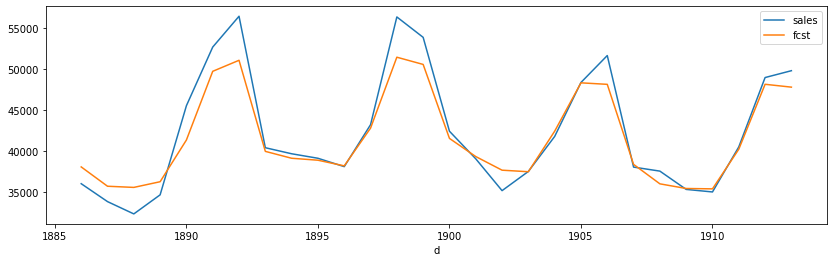

In [25]:
fcst_df.groupby(["d"])[["sales", "fcst"]].sum().plot()

## Evaluate

In [28]:
fcst_bu = bottom_up(fcst_df, ["fcst"])
val_bu = bottom_up(fcst_df, ["sales"])

<AxesSubplot:xlabel='d'>

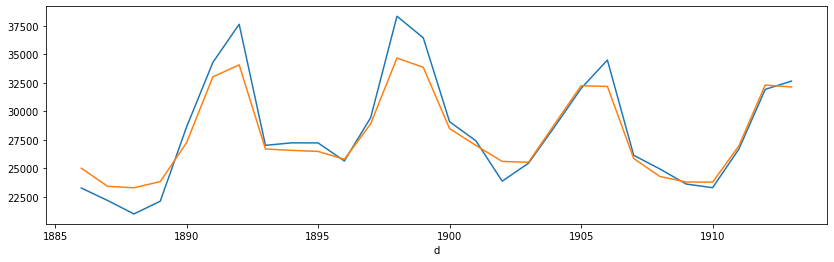

In [185]:
idx = "4-0"
y_train = train_bu.loc[train_bu.id == idx, ["d", "sales"]].set_index("d").iloc[:, 0]
y_val = val_bu.loc[val_bu.id == idx, ["d", "sales"]].set_index("d").iloc[:, 0]
y_fcst = fcst_bu.loc[fcst_bu.id == idx, ["d", "fcst"]].set_index("d").iloc[:, 0]

#y_train.plot()
y_val.plot()
y_fcst.plot()
#plt.xlim(left=1800)

In [197]:
score = calculate_rmsse(train_bu, val_bu, fcst_bu)

In [199]:
score

id
12-2350-2     0.026382
12-2595-4     0.029362
12-1763-5     0.042804
12-1763-6     0.053934
12-54-4       0.055547
               ...    
12-1442-3     8.344412
12-1436-3     9.222049
12-1840-3    10.053432
12-2177-2    13.607274
12-2021-2    17.615623
Length: 42831, dtype: float64

## Playground